In [31]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


In [16]:
def load_and_preprocess_data(data_path):
    """Load and preprocess the emission data"""
    # Load data
    df = pd.read_csv(data_path)

    # Split the ID column into separate features
    df[['lat', 'lon', 'year', 'week']] = df['ID_LAT_LON_YEAR_WEEK'].str.split('_', expand=True).iloc[:, 1:5]

    # Convert columns to appropriate types
    df['lat'] = df['lat'].astype(float)
    df['lon'] = df['lon'].astype(float)
    df['year'] = df['year'].astype(int)
    df['week'] = df['week'].astype(int)

    # Create emission level categories based on emission values
    # Use more balanced thresholds
    emission_thresholds = {
        'Low': df['emission'].quantile(0.25),
        'Medium': df['emission'].quantile(0.75)
    }

    # Create emission level categories
    df['emission_level'] = pd.cut(
        df['emission'],
        bins=[-float('inf'), emission_thresholds['Low'], emission_thresholds['Medium'], float('inf')],
        labels=['Low', 'Medium', 'High']
    )

    # Split features and target
    X = df[['lat', 'lon', 'year', 'week']]
    y = df['emission_level']

    # Encode target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Use stratified sampling for train/val/test split

    # First split: 70% train, 30% temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_scaled_df, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
    )

    # Second split: 15% val, 15% test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, le


In [17]:
def save_preprocessors(scaler, label_encoder, model_path='saved_models'):
    """Save preprocessing objects"""
    Path(model_path).mkdir(parents=True, exist_ok=True)
    joblib.dump(scaler, f'{model_path}/scaler.joblib')
    joblib.dump(label_encoder, f'{model_path}/label_encoder.joblib')


In [18]:
def load_preprocessors(model_path='saved_models'):
    """Load preprocessing objects"""
    scaler = joblib.load(f'{model_path}/scaler.joblib')
    label_encoder = joblib.load(f'{model_path}/label_encoder.joblib')
    return scaler, label_encoder


In [29]:
def train_model(data_path, model_path='saved_models'):
    """Train XGBoost model and save it"""
    # Load and preprocess data
    X_train, X_val, X_test, y_train, y_val, y_test, scaler, le = load_and_preprocess_data(data_path)

    # Save preprocessors
    save_preprocessors(scaler, le, model_path)

    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Initialize and train XGBoost model with class weights
    model = xgb.XGBClassifier(
        learning_rate=0.01,
        n_estimators=1000,  # Increased number of trees
        max_depth=5,        # Increased depth
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1,
        scale_pos_weight=weight_dict,  # Add class weights
        random_state=42,
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss'  # Add evaluation metric
    )

    # Train the model
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=True
    )

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_acc:.4f}")
    print("\nClassification Report (Validation):")
    print(classification_report(y_val, y_val_pred))

    # Save the model
    model.save_model(f'{model_path}/xgboost_model.json')

    return model, X_test, y_test


In [20]:
def load_model(model_path='saved_models/xgboost_model.json'):
    """Load the trained XGBoost model"""
    model = xgb.XGBClassifier()
    model.load_model(model_path)
    return model

In [21]:
def predict_emission(model, data, scaler, label_encoder):
    """Make predictions on new data"""
    # Ensure data has required columns
    required_cols = ['lat', 'lon', 'year', 'week']
    if not all(col in data.columns for col in required_cols):
        raise ValueError(f"Data must contain columns: {required_cols}")

    # Scale features
    X = scaler.transform(data[required_cols])

    # Make predictions
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)

    # Convert numeric predictions to labels
    predicted_labels = label_encoder.inverse_transform(predictions)

    # Create results DataFrame
    results = pd.DataFrame({
        'Predicted_Class': predicted_labels,
        'Probability_Low': probabilities[:, 0],
        'Probability_Medium': probabilities[:, 1],
        'Probability_High': probabilities[:, 2]
    })

    return results

In [22]:
def plot_feature_importance(model, feature_names):
    """Plot feature importance"""
    importance = model.feature_importances_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance, y=feature_names)
    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

In [23]:
def plot_prediction_distribution(results):
    """Plot distribution of predictions"""
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Predicted_Class', data=results)
    plt.title('Distribution of Predicted Classes')
    plt.xlabel('Emission Level')
    plt.ylabel('Count')
    plt.show()


Training model...
[0]	validation_0-mlogloss:1.09381


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:23:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:1.08967
[2]	validation_0-mlogloss:1.08720
[3]	validation_0-mlogloss:1.08342
[4]	validation_0-mlogloss:1.07985
[5]	validation_0-mlogloss:1.07598
[6]	validation_0-mlogloss:1.07213
[7]	validation_0-mlogloss:1.06783
[8]	validation_0-mlogloss:1.06437
[9]	validation_0-mlogloss:1.05952
[10]	validation_0-mlogloss:1.05733
[11]	validation_0-mlogloss:1.05506
[12]	validation_0-mlogloss:1.05057
[13]	validation_0-mlogloss:1.04690
[14]	validation_0-mlogloss:1.04298
[15]	validation_0-mlogloss:1.03858
[16]	validation_0-mlogloss:1.03605
[17]	validation_0-mlogloss:1.03198
[18]	validation_0-mlogloss:1.02872
[19]	validation_0-mlogloss:1.02614
[20]	validation_0-mlogloss:1.02245
[21]	validation_0-mlogloss:1.01859
[22]	validation_0-mlogloss:1.01517
[23]	validation_0-mlogloss:1.01150
[24]	validation_0-mlogloss:1.00763
[25]	validation_0-mlogloss:1.00494
[26]	validation_0-mlogloss:1.00128
[27]	validation_0-mlogloss:0.99791
[28]	validation_0-mlogloss:0.99384
[29]	validation_0-mlogloss:0.

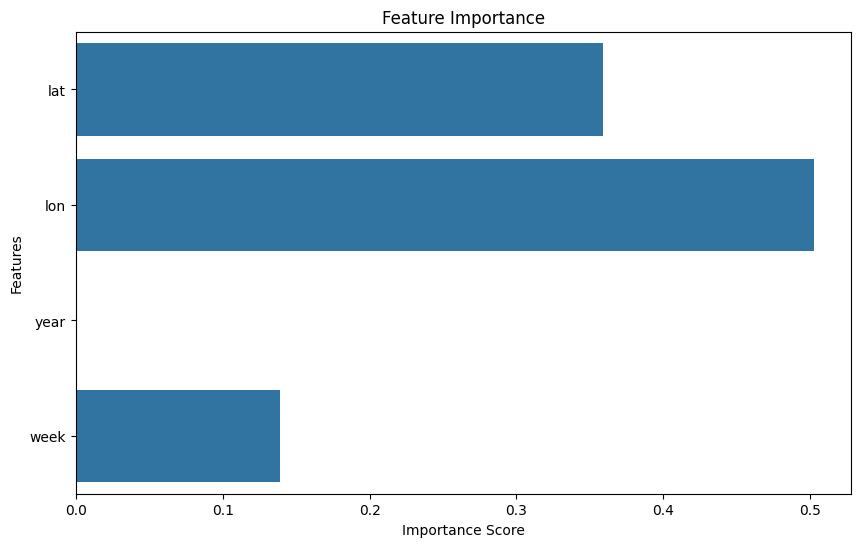


Making example prediction...

Prediction Results:
  Predicted_Class  Probability_Low  Probability_Medium  Probability_High
0             Low         0.017741            0.939912          0.042348

Plotting prediction distribution...


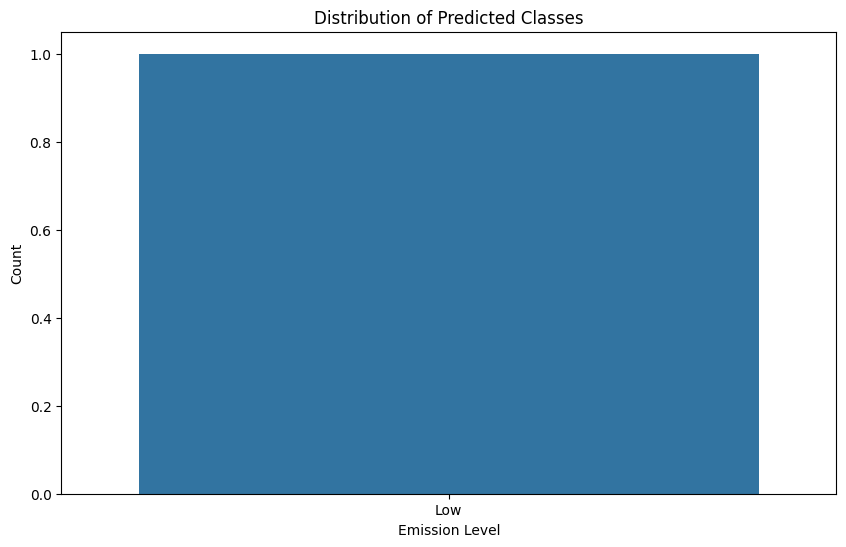

In [33]:
    Path('saved_models').mkdir(parents=True, exist_ok=True)

    # Train the model
    print("Training model...")
    model, X_test, y_test = train_model("emissions.csv")

    # Final evaluation on test set
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"\nTest Accuracy: {test_acc:.4f}")
    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_test_pred))

    # Plot feature importance
    print("\nPlotting feature importance...")
    plot_feature_importance(model, ['lat', 'lon', 'year', 'week'])

    # Make example prediction
    print("\nMaking example prediction...")
    example_data = pd.DataFrame({
        'lat': [40.7128],
        'lon': [-74.0060],
        'year': [2023],
        'week': [1]
    })

    # Load preprocessors
    scaler, label_encoder = load_preprocessors()

    # Make prediction
    results = predict_emission(model, example_data, scaler, label_encoder)
    print("\nPrediction Results:")
    print(results)

    # Plot prediction distribution
    print("\nPlotting prediction distribution...")
    plot_prediction_distribution(results)